# MSIN0114 - Dissertation
# Notebook 3 - Run Model and Eval

# Import Necessary Library

In [1]:
!pip install -U scikit-learn
!pip install xgboost
!pip install imbalanced_learn
!pip install shap
!pip install pandarallel

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import pandas as pd
import numpy as np
from functools import reduce
import glob
import time
import datetime

now = datetime.datetime.now()

from itertools import tee, islice, chain

#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FixedLocator, FixedFormatter

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(rc={"figure.figsize":(11.7,8.27)})

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

# machine learning libraries
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.impute import SimpleImputer
from numpy.random import seed
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
import shap

# ensemble method libraries
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install keras
# neural network libraries
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached scikit_learn-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1

         .:::.     .::.       
        ....yy:   

In [2]:
import requests

def telegram_bot_sendtext(bot_message):

    bot_token = '5544013184:AAEFue_7v4qLcmHEdS2uHBWU2hpQAczrZmU'
    bot_chatID = '1452370484'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()

# Import Data from Notebook 1

In [3]:
final_model_data = pd.read_csv('final_model_data.csv', 
                      lineterminator='\n',
                      delimiter=',')

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
final_data = final_model_data.copy()

# Data Splitting

In [5]:
# split the X and y in both train and test data
y = final_data["is_recurring"].astype(int)
X = final_data.drop(["is_recurring",'Phone','Order_Number','Order_MY'],axis=1).astype(float)

In [6]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_backup = X_train.copy()
X_test_backup = X_test.copy()

print("train_final")
print("rows: " + str(X_train.shape[0]))
print("columns: " + str(X_train.shape[1]))

print("\n")

print("test_final")
print("rows: " + str(X_test.shape[0]))
print("columns: " + str(X_test.shape[1]))


train_final
rows: 3986066
columns: 124


test_final
rows: 1328689
columns: 124


# Imputer

In [7]:
# Handle missing values
from sklearn.impute import SimpleImputer
def transform_imputer(data):
    cols = list(data.columns.values[1:])
    
    data['prev_month'][data['prev_month'].isna()] = 0
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')

    # #fill remaining nan with 0
    # df_final = np.nan_to_num(df_final, posinf=33333333, neginf=-33333333)
    imp = imp.fit(data[cols])
    data[cols] = pd.DataFrame(imp.transform(data[cols]))
    return data

In [8]:
X_train = transform_imputer(X_train)
X_test = transform_imputer(X_test)

# Data Scaling

In [9]:
# scale the final X_train and X_test data
scaler = StandardScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns);
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns);

# Model

## Baseline Model - Decision Tree

In [10]:
start_time = time.time()

# Decision Tree baseline model
dt = DecisionTreeClassifier(random_state=8888)

cross_val_score_dt = cross_val_score(dt, X_train, y_train, cv=5, verbose=1, n_jobs=-1)
cross_val_score_dt
print('Cross Validation score mean:', cross_val_score_dt.mean())

print("--- %s seconds ---" % (time.time() - start_time))


# Telebot
telebot = telegram_bot_sendtext('*Decision Tree*' + 
                             '\nCross Validation Mean: ' + str(cross_val_score_dt.mean()) + 
                             '\nTime Elapsed: ' + str((time.time() - start_time)) + ' secs')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Cross Validation score mean: 0.6956056421394792
--- 90.12765407562256 seconds ---


## Advanced Model

## Random Forest

In [11]:
start_time = time.time()

# random forest baseline model
clf_forest = RandomForestClassifier(random_state=8888)

cross_val_score_rf = cross_val_score(clf_forest, X_train, y_train, cv=5, verbose=1, n_jobs=-1)
cross_val_score_rf
print('Cross Validation score mean:', cross_val_score_rf.mean())

print("--- %s seconds ---" % (time.time() - start_time))

# Telebot
telebot = telegram_bot_sendtext('*Random Forest*' + 
                             '\nCross Validation Mean: ' + str(cross_val_score_rf.mean()) + 
                             '\nTime Elapsed: ' + str((time.time() - start_time)) + ' secs')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 24.2min remaining: 36.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.6min finished


Cross Validation score mean: 0.7156356667434256
--- 1476.8021850585938 seconds ---


In [12]:
start_time = time.time()

# hyperparameters
from sklearn.model_selection import GridSearchCV
params_grid_rf = {
    'max_depth': [50,100],
    'min_samples_leaf' : [25,50],
    'min_samples_split' : [50,100]}
# Grid search 
grid_search_rf = GridSearchCV(estimator = clf_forest,
                              param_grid = params_grid_rf,
                              scoring='precision',
                              cv = 5, 
                              n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print('Best Accuracy Score:', grid_search_rf.best_score_) 
print('Best Input Parameters:', grid_search_rf.best_params_)

print("--- %s seconds ---" % (time.time() - start_time))

# Telebot
a = []
for i in range(len(grid_search_rf.best_params_.keys())):
    a.append(list(grid_search_rf.best_params_.keys())[i] + ': ' + str(list(grid_search_rf.best_params_.values())[i]))
    
a = '\n'.join([str(item) for item in a])
a = a.replace('_',' ')

telebot = telegram_bot_sendtext('*Rando Forest Gridsearch*\n' + a +
                             '\nBest Precision Score: ' + str(grid_search_rf.best_score_) + 
                             '\nTime Elapsed: ' + str((time.time() - start_time)) + ' secs')

Best Accuracy Score: 0.7550922361364067
Best Input Parameters: {'max_depth': 100, 'min_samples_leaf': 50, 'min_samples_split': 50}
--- 4592.240888118744 seconds ---


In [13]:
clf_rf_tuned = RandomForestClassifier(**grid_search_rf.best_params_, random_state=8888)

## XGBoost

In [14]:
start_time = time.time()

#Train the model using default hyperparameters
clf_xgb = XGBClassifier(random_state=8888, eval_metric='logloss', use_label_encoder=False)

cross_val_score_xgb = cross_val_score(clf_xgb, X_train, y_train, cv=3, verbose=1, n_jobs=-1)
cross_val_score_xgb
print('Cross Validation score mean:', cross_val_score_xgb.mean())

print("--- %s seconds ---" % (time.time() - start_time))

# Telebot
telebot = telegram_bot_sendtext('*XGBoost*' + 
                             '\nBest Accuracy Score: ' + str(cross_val_score_xgb.mean()) + 
                             '\nTime Elapsed: ' + str((time.time() - start_time)) + ' secs')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.7min finished


Cross Validation score mean: 0.7511481244381383
--- 344.8203263282776 seconds ---


In [16]:
start_time = time.time()
# A parameter grid for XGBoost

min_child_weight = [1]
max_depth = [1]
gamma = [0.0]
subsample = [0.875]
colsample_bytree = [0.525]
learning_rate = [0.01]



params_grid_xgb = dict(
        min_child_weight=min_child_weight,
        max_depth=max_depth,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        learning_rate = learning_rate
)

grid_search_xgb = GridSearchCV(estimator=clf_xgb,
                               param_grid=params_grid_xgb, 
                               scoring='precision',
                               cv = 2,
                               n_jobs=-1
                           )

grid_search_xgb.fit(X_train, y_train)


print('Best Precision Score:', grid_search_xgb.best_score_) 
print('Best Input Parameters:', grid_search_xgb.best_params_)

print("--- %s seconds ---" % (time.time() - start_time))

# Telebot
a = []
for i in range(len(grid_search_xgb.best_params_.keys())):
    a.append(list(grid_search_xgb.best_params_.keys())[i] + ': ' + str(list(grid_search_xgb.best_params_.values())[i]))
    
a = '\n'.join([str(item) for item in a])
a = a.replace('_',' ')

telebot = telegram_bot_sendtext('*XGBoost Gridsearch*\n' + a +
                             '\nBest Precision Score: ' + str(grid_search_xgb.best_score_) + 
                             '\nTime Elapsed: ' + str((time.time() - start_time)) + ' secs')

Best Precision Score: 0.8164612005540226
Best Input Parameters: {'colsample_bytree': 0.525, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.875}
--- 84.97607922554016 seconds ---


In [17]:
clf_xgboost_tuned = XGBClassifier(**grid_search_xgb.best_params_, random_state=8888)

## Neural Network

In [19]:
model = Sequential()
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.add(Dense(500, activation='relu', input_shape = (124,) ))
model.add(Dense(250, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, loss='binary_crossentropy',
        metrics= [keras.metrics.BinaryAccuracy(name='accuracy'),
               keras.metrics.Precision(name='precision'),
               keras.metrics.Recall(name='recall')]
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               62500     
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_3 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1900      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 222,351
Trainable params: 222,351
Non-trainable params: 0
__________________________________________________

In [20]:
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.3, shuffle=True)

Epoch 1/10
279025/279025 [==============================] - 508s 2ms/step - loss: 0.5081 - accuracy: 0.7463 - precision: 0.7523 - recall: 0.5324 - val_loss: 0.5053 - val_accuracy: 0.7476 - val_precision: 0.7733 - val_recall: 0.5095
Epoch 2/10
279025/279025 [==============================] - 507s 2ms/step - loss: 0.5042 - accuracy: 0.7475 - precision: 0.7473 - recall: 0.5444 - val_loss: 0.5034 - val_accuracy: 0.7482 - val_precision: 0.7622 - val_recall: 0.5257
Epoch 3/10
279025/279025 [==============================] - 507s 2ms/step - loss: 0.5034 - accuracy: 0.7478 - precision: 0.7461 - recall: 0.5473 - val_loss: 0.5035 - val_accuracy: 0.7482 - val_precision: 0.7502 - val_recall: 0.5423
Epoch 4/10
279025/279025 [==============================] - 507s 2ms/step - loss: 0.5030 - accuracy: 0.7481 - precision: 0.7476 - recall: 0.5461 - val_loss: 0.5024 - val_accuracy: 0.7482 - val_precision: 0.7691 - val_recall: 0.5166
Epoch 5/10
279025/279025 [==============================] - 507s 2ms/ste

In [22]:
print(now)

2022-07-22 10:56:34.747474


In [23]:
y_pred_NN_prob = model.predict(X_test).flatten()

In [24]:
listnn = ['0.41', '0.42', '0.43', '0.44', '0.45', '0.46', '0.47', '0.48', '0.49', '0.50', 
          '0.51', '0.52', '0.53', '0.54', '0.55', '0.56', '0.57', '0.58', '0.59', '0.60']
listresult = {}
for i in listnn:
    y_pred_NN = (y_pred_NN_prob > float(i)).astype('int64')
    a = accuracy_score(y_test, y_pred_NN)
    p = precision_score(y_test, y_pred_NN)
    r = recall_score(y_test, y_pred_NN)
    listresult.setdefault('rounding', [])
    listresult['rounding'].append(i)
    listresult.setdefault('accuracy', [])
    listresult['accuracy'].append(a)
    listresult.setdefault('precision', [])
    listresult['precision'].append(p)
    listresult.setdefault('recall', [])
    listresult['recall'].append(r)

listresult = pd.DataFrame.from_dict(listresult)

In [25]:
var = float(listresult['rounding'].loc[listresult[['recall']].idxmax()].values)
y_pred_NN = (y_pred_NN_prob > var).astype('int64')

In [26]:
print(now)

2022-07-22 10:56:34.747474


## Voting Classifier

In [28]:
start_time = time.time()

eclf = VotingClassifier(estimators=[('DT', dt), ('XGB', clf_xgb), ('RF', clf_rf_tuned)],
                        voting='soft', weights=[1,1,1], n_jobs=-1)

eclf.fit(X_train, y_train)
eclf_score = eclf.score(X_train, y_train)
print('Ensemble Voting Classifier score mean:', eclf_score.mean())

print("--- %s seconds ---" % (time.time() - start_time))

Ensemble Voting Classifier score mean: 0.8972488162514118
--- 1126.888703584671 seconds ---


In [30]:
start_time = time.time()

eclf2 = VotingClassifier(estimators=[('DT', dt), ('XGB', clf_xgb), ('RF', clf_rf_tuned)],
                        voting='hard', weights=[1,1,1], n_jobs=-1)

eclf2.fit(X_train, y_train)
eclf2_score = eclf2.score(X_train, y_train)
print('Ensemble Voting Classifier score mean:', eclf2_score.mean())

print("--- %s seconds ---" % (time.time() - start_time))

Ensemble Voting Classifier score mean: 0.7688663459159983
--- 1414.9196321964264 seconds ---


In [31]:
start_time = time.time()

eclf3 = VotingClassifier(estimators=[('XGB', clf_xgb), ('RF', clf_rf_tuned)],
                        voting='soft', weights=[1,1], n_jobs=-1)

eclf3.fit(X_train, y_train)
eclf3_score = eclf3.score(X_train, y_train)
print('Ensemble Voting Classifier score mean:', eclf3_score.mean())

print("--- %s seconds ---" % (time.time() - start_time))

Ensemble Voting Classifier score mean: 0.7549335610599524
--- 1105.0254368782043 seconds ---


In [32]:
start_time = time.time()

eclf4 = VotingClassifier(estimators=[('XGB', clf_xgb), ('RF', clf_rf_tuned)],
                        voting='hard', weights=[1,1], n_jobs=-1)

eclf4.fit(X_train, y_train)
eclf4_score = eclf4.score(X_train, y_train)
print('Ensemble Voting Classifier score mean:', eclf4_score.mean())

print("--- %s seconds ---" % (time.time() - start_time))

Ensemble Voting Classifier score mean: 0.7541706534713675
--- 1131.218915939331 seconds ---


## Predict and Evaluate using Test Dataset

In [34]:
start_time = time.time()

# fit and predict on test
dt.fit(X_train, y_train)
y_pred_DT = dt.predict(X_test)

# fit and predict on test
clf_rf_tuned.fit(X_train, y_train)
y_pred_RF = clf_rf_tuned.predict(X_test)

# fit and predict on test
clf_xgboost_tuned.fit(X_train, y_train)
y_pred_XGB = clf_xgboost_tuned.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1497.4346044063568 seconds ---


In [35]:
start_time = time.time()

# predict using ensemble method on test
y_pred_ECLF = eclf.predict(X_test)
y_pred_ECLF2 = eclf2.predict(X_test)
y_pred_ECLF3 = eclf3.predict(X_test)
y_pred_ECLF4 = eclf4.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 169.16397166252136 seconds ---


In [39]:
# A dictionary of model names with the various metrics
ref_xgb_log_reg_dict = {"model_name" : ['Decision Tree', 'Random Forest', 'XG Boost', 'ECLF', 'ECLF2','ECLF3','ECLF4','NN'], 
                        "accuracy"   : [accuracy_score(y_test, y_pred_DT), accuracy_score(y_test, y_pred_RF), accuracy_score(y_test, y_pred_XGB), accuracy_score(y_test, y_pred_ECLF), accuracy_score(y_test, y_pred_ECLF2), accuracy_score(y_test, y_pred_ECLF3), accuracy_score(y_test, y_pred_ECLF4), accuracy_score(y_test, y_pred_NN)], 
                        "f1_score"   : [f1_score(y_test, y_pred_DT), f1_score(y_test, y_pred_RF), f1_score(y_test, y_pred_XGB), f1_score(y_test, y_pred_ECLF), f1_score(y_test, y_pred_ECLF2), f1_score(y_test, y_pred_ECLF3), f1_score(y_test, y_pred_ECLF4), f1_score(y_test, y_pred_NN)], 
                        "recall"     : [recall_score(y_test, y_pred_DT), recall_score(y_test, y_pred_RF), recall_score(y_test, y_pred_XGB), recall_score(y_test, y_pred_ECLF), recall_score(y_test, y_pred_ECLF2), recall_score(y_test, y_pred_ECLF3), recall_score(y_test, y_pred_ECLF4), recall_score(y_test, y_pred_NN)], 
                        "precision"  : [precision_score(y_test, y_pred_DT), precision_score(y_test, y_pred_RF), precision_score(y_test, y_pred_XGB), precision_score(y_test, y_pred_ECLF), precision_score(y_test, y_pred_ECLF2), precision_score(y_test, y_pred_ECLF3), precision_score(y_test, y_pred_ECLF4), precision_score(y_test, y_pred_NN)]
                       }

# Create a dataframe with ref_xgb_log_reg_dict
ref_xgb_log_reg_df = pd.DataFrame(ref_xgb_log_reg_dict).set_index("model_name")

# Order the dataframe ref_xgb_log_reg_df by the metric values in increasing order
ref_xgb_log_reg_df.sort_values(by=["precision", "f1_score", "recall", "precision"], ascending=False)

,accuracy,f1_score,recall,precision
model_name,,,,
XG Boost,0.742558,0.578808,0.448291,0.816540
ECLF4,0.750510,0.627046,0.531524,0.764425
Random Forest,0.750703,0.633922,0.547021,0.753649
ECLF3,0.749006,0.648289,0.586234,0.725038
ECLF2,0.740089,0.651180,0.614820,0.692110
NN,0.739021,0.678433,0.697694,0.660206
ECLF,0.682570,0.615472,0.643802,0.589530
Decision Tree,0.653734,0.585364,0.619432,0.554848


## Feature Importance

In [40]:
clf_xgboost_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.525,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=8888, reg_alpha=0, reg_lambda=1, ...)

In [41]:
explainer = shap.TreeExplainer(clf_xgboost_tuned)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


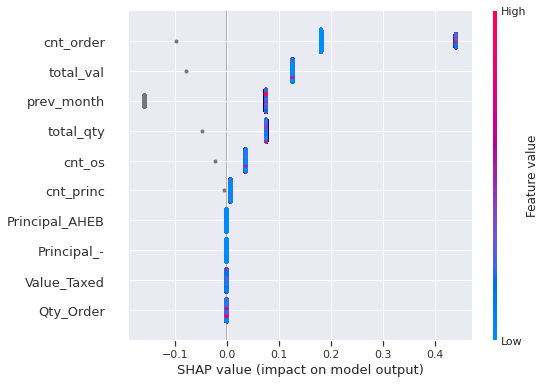

In [57]:
shap.summary_plot(shap_values[0:2000000,:10], X.iloc[0:2000000,:10])

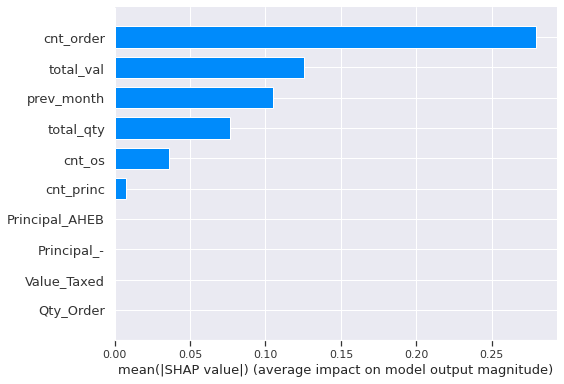

In [58]:
shap.summary_plot(shap_values[0:2000000,:10], X.iloc[0:2000000,:10], feature_names=X.columns, plot_type='bar')

## Confusion Matrix

In [56]:
def cm(data):
    cm = confusion_matrix(y_test, data)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap='viridis', values_format='')
    plt.grid(False)
    return plt.show()

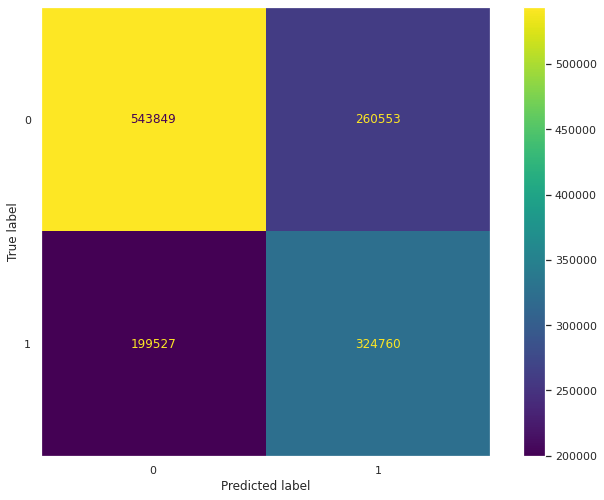

In [61]:
cm(y_pred_DT)

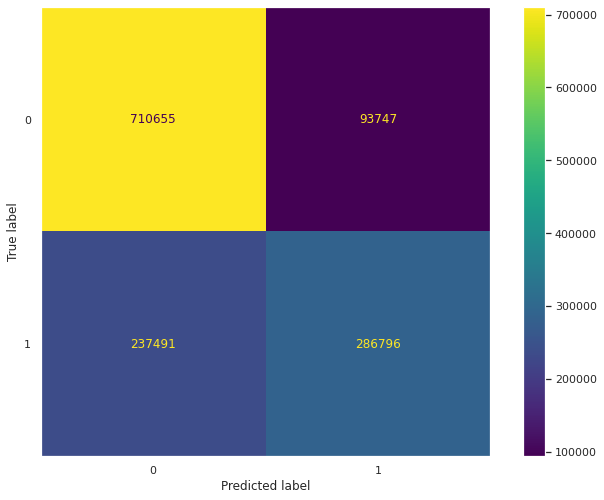

In [62]:
cm(y_pred_RF)

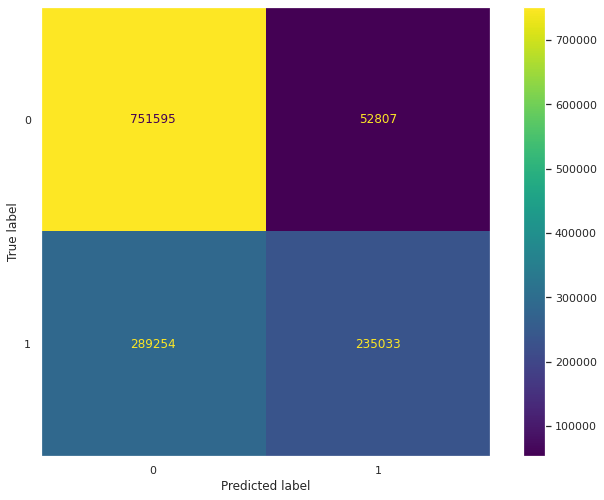

In [63]:
cm(y_pred_XGB)

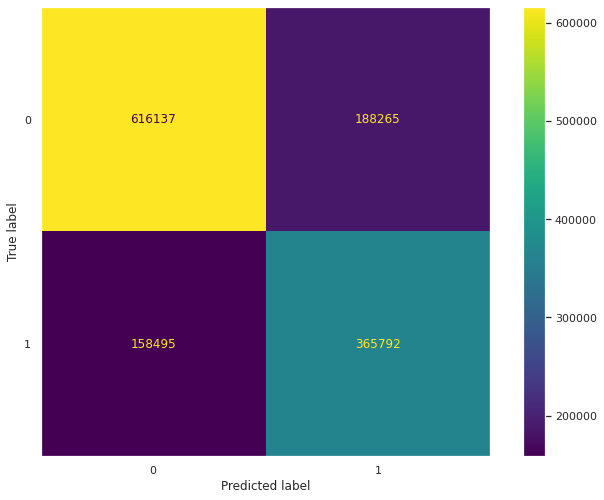

In [64]:
cm(y_pred_NN)

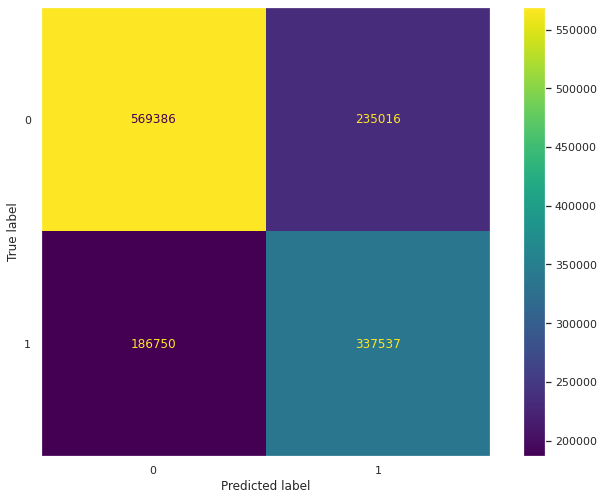

In [66]:
cm(y_pred_ECLF)

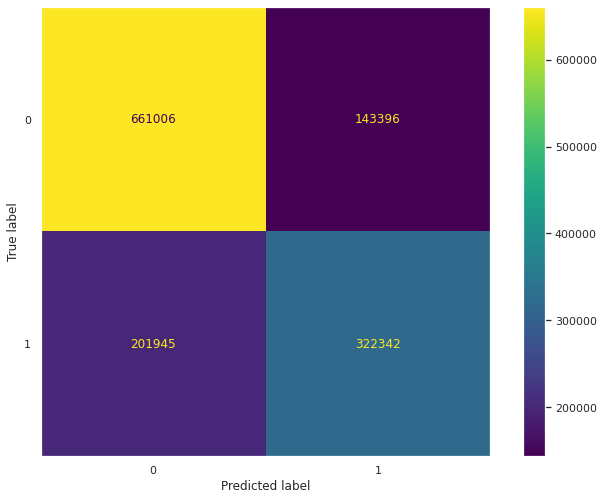

In [67]:
cm(y_pred_ECLF2)

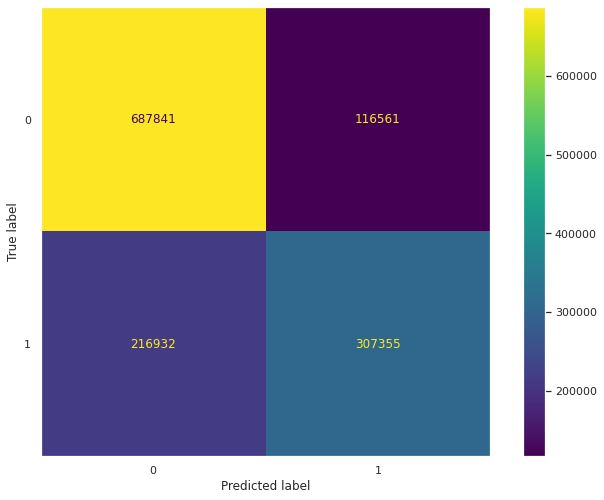

In [68]:
cm(y_pred_ECLF3)

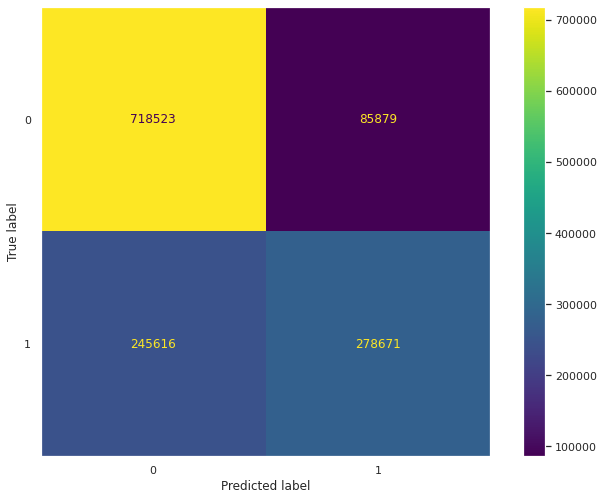

In [69]:
cm(y_pred_ECLF4)

# ROC Curves

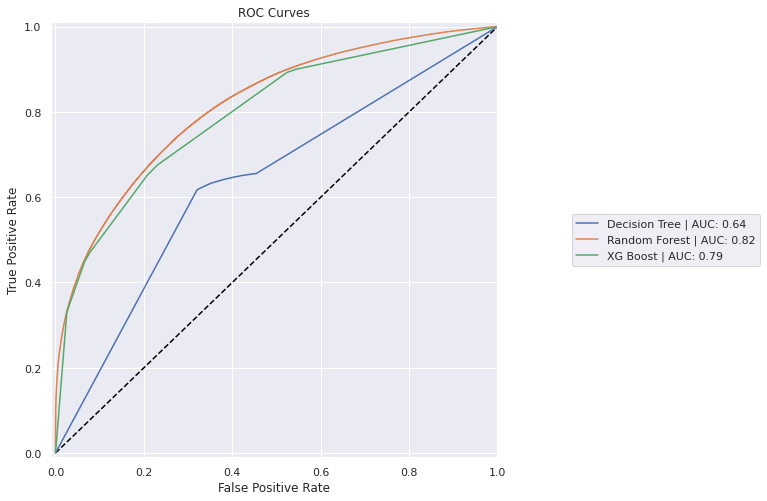

In [78]:
# list of model functions
models = {
    "Decision Tree": dt,
    "Random Forest": clf_rf_tuned,
    "XG Boost": clf_xgboost_tuned
}

# set up figure
fig = plt.figure(figsize=(8,8))

# random classifier ROC curve
sns.lineplot(x=[0,1], y=[0,1], linestyle='--', color='black', label=None) # random classifier

# plot ROC curve for each model
for model in models:
    m = models[model]
    m.fit(X_train, y_train)
    y_pred = m.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred)
    auc = roc_auc_score(y_test.values, y_pred).round(2)
    
    sns.lineplot(x=fpr, y=tpr, label=(model + " | AUC: " + str(auc)))

# customize x axis
plt.xlim(-0.01,1)
plt.xlabel('False Positive Rate')
# customize y axis
plt.ylim(-0.01,1.01)
plt.ylabel('True Positive Rate')

plt.title('ROC Curves')

plt.legend(loc=7, bbox_to_anchor=(1.6,0.5))

plt.show();